This notebook is for defining and applying two supervised learning methods: support vector machine (SVM) and Random Forest. Model inputs include data from both areas of interest: Koumassi and Southeast. Files to be included in model were labled with "raw" in the calculating_spectral_indices notebooks. Model inputs were determined based on earlier explorations and include the following 8 parameters: 
- "Dark" parameter: sum of red-edge, NIR1, and NIR2 bands
- Morphological building index (MBI)
- Morphological shadow index (MSI)
- Normalized difference vegetation index (NDVI)
- Normalized difference water index (coastal/NIR2, NDWI)
- NDWIcoastal/NIR2 - MSI (difference)
- Normalized difference water index (yellow/NIR2, NDWI)
- NDWIyellow/NIR2 - MSI (difference)


*Note that some cells have been commented out after the best model had been saved to avoid over-writing.

In [68]:
# Import necessary packages
import os
import pickle
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import rasterio as rio
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import earthpy as et
import earthpy.spatial as es

In [70]:
# Define areas of interest and paths
aoi = 'koumassi_focus_ps'
koumassi_band_path = '..\\data\\'+aoi+"\\"
koumassi_raster_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\raster_files\\")
koumassi_svm_outputs_path = os.path.join(
    koumassi_band_path, "final_outputs\\svm\\")

aoi2 = 'southeast_ps'
southeast_band_path = '..\\data\\'+aoi2+"\\"
southeast_raster_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\raster_files\\")
southeast_svm_outputs_path = os.path.join(
    southeast_band_path, "final_outputs\\svm\\")

# Check for and/or create combined folder
combined_svm_outputs_path = '..\\data\\combined\\'
try:
    os.makedirs(combined_svm_outputs_path)
except FileExistsError:
    print("band_path directory already exists!")

# Select all raw index/band value tif files needed for model inputs
# Files to be included in model were labled with "raw" in the calculating_spectral_indices notebooks
koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
koumassi_raw_list.sort()
southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
southeast_raw_list.sort()

band_path directory already exists!


In [71]:
# Set paths for validation data inputs
validation_data_path = os.path.join('..\\data\\combined\\validation\\')
koumassi_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_koumassi.shp")
southeast_sample_pts = gpd.read_file(
    validation_data_path+"vector-data\\additional_val_points_southeast.shp")

In [72]:
# Get meta data for writing out SVM result
koumassi_all_bands_path = os.path.join(
    koumassi_raster_outputs_path + aoi+"_all_bands.tif")
with rio.open(koumassi_all_bands_path) as src:
    koumassi_all_bands_stack = src.read()
    stack_meta = src.meta
    koumassi_files_out_meta = src.meta.copy()
koumassi_files_out_meta['count'] = 1


# Get meta data for writing out SVM result
southeast_all_bands_path = os.path.join(
    southeast_raster_outputs_path + aoi2+"_all_bands.tif")
with rio.open(southeast_all_bands_path) as src:
    southeast_all_bands_stack = src.read()
    stack_meta = src.meta
    southeast_files_out_meta = src.meta.copy()
southeast_files_out_meta['count'] = 1

In [122]:
# Sample index values at reference points for koumassi
# Create tuples of all x coordinates and y coordinates
x_coords_koumassi = tuple(koumassi_sample_pts.geometry.x)
y_coords_koumassi = tuple(koumassi_sample_pts.geometry.y)

i = 0
index_list = []
filename = []

for raw in koumassi_raw_list:
    sampled_values = []

    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords_koumassi, y_coords_koumassi)):
            i = i+1

        # Note that each val is an individual numpy array
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[57:77])

labels = filename
index_vals_koumassi = pd.DataFrame(np.concatenate(index_list))
index_vals_koumassi = index_vals_koumassi.transpose()
index_vals_koumassi.columns = labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_koumassi.csv"
index_vals_koumassi.to_csv(filepath)

In [113]:
# Sample index values at reference points for southeast
# Create tuples of all x coordinates and y coordinates
x_coords_southeast = tuple(southeast_sample_pts.geometry.x)
y_coords_southeast = tuple(southeast_sample_pts.geometry.y)

i = 0
index_list = []
filename = []

for raw in southeast_raw_list:
    sampled_values = []

    # Sample raster at each combo of x and y coordinates
    with rio.open(raw) as src:
        for val in src.sample(zip(x_coords_southeast, y_coords_southeast)):
            i = i+1
        # Note that each val is an individual numpy array
            sampled_values.append(val)
        arr = np.array([sampled_values]).squeeze()
        index_list.append([arr])
        filename.append(raw[52:76])

labels = filename
index_vals_southeast = pd.DataFrame(np.concatenate(index_list))
index_vals_southeast = index_vals_southeast.transpose()
index_vals_southeast.columns = labels

# Write out index values for reference points as CSV
filepath = validation_data_path+"index_vals_southeast.csv"
index_vals_southeast.to_csv(filepath)

In [123]:
# Combine validation data with index values for koumassi
valid_data_koumassi = pd.read_csv(
    validation_data_path+"additional_val_points_koumassi.csv")
train_data_koumassi = pd.concat(
    [valid_data_koumassi, index_vals_koumassi], axis=1, sort=False)
train_data_koumassi.head()

,OBJECTID,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,1,2,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,2,2,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,3,1,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,4,1,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,5,1,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [124]:
# Combine validation data with index values for southeast
valid_data_southeast = pd.read_csv(
    validation_data_path+"additional_val_points_southeast.csv")
train_data_southeast = pd.concat(
    [valid_data_southeast, index_vals_southeast], axis=1, sort=False)
train_data_southeast.head()

,OBJECTID,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,1,2,0.7526,0.032580,0.026123,0.134679,-0.394132,-0.420254,-0.157594,-0.183717
1,2,2,0.8285,0.006114,0.043177,0.149244,-0.365778,-0.408955,-0.215826,-0.259003
2,3,2,0.3688,0.013539,0.026273,-0.286490,0.103074,0.076801,0.495422,0.469150
3,4,2,0.4671,0.010830,0.007302,-0.212443,-0.026115,-0.033418,0.419335,0.412033
4,5,2,0.5042,0.019964,0.005632,-0.178983,-0.076766,-0.082397,0.373623,0.367991


In [133]:
# Merge koumassi and southeast training data
train_data = train_data_koumassi.append(train_data_southeast)
train_data = train_data.drop(['OBJECTID'], axis=1)
train_data.head()

,ClassValue,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,2,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,2,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,1,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,1,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,1,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [134]:
# Define training dataset
XX = train_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]]
X = train_data.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8]].values
y = train_data.iloc[:, 0].values
XX.head()

,dark.tif,mbi.tif,msi.tif,ndvi.tif,ndwi_coastal.tif,ndwi_coastal_msi.tif,ndwi_yellow.tif,ndwi_yellow_msi.tif
0,0.1846,0.001091,0.111064,-0.011570,-0.000799,-0.111863,0.000000,-0.111064
1,0.1706,0.005009,0.094227,-0.029991,0.092105,-0.002122,0.043328,-0.050900
2,0.1630,0.000000,0.131636,0.006560,-0.106168,-0.237804,-0.013902,-0.145538
3,0.1616,0.002909,0.142139,-0.008547,-0.044550,-0.186688,-0.024164,-0.166302
4,0.1916,0.000000,0.182211,0.021898,-0.168335,-0.350546,-0.039676,-0.221887


In [135]:
# Commented out to avoid overwriting final datasets
# Split reference dataset, hold back 40% for external validation, 60% for internal train/test
# Xint, Xext, yint, yext = train_test_split(X, y, test_size=0.4)

In [ ]:
# Commented out to avoid overwriting final datasets
# Write out training/testing and external validation datasets
# pd.DataFrame(Xext).to_csv(combined_svm_outputs_path+"Xext_add_points_v4.csv")
# pd.DataFrame(yext).to_csv(combined_svm_outputs_path+"yext_add_points_v4.csv")
# pd.DataFrame(Xint).to_csv(combined_svm_outputs_path+"Xint_add_points_v4.csv")
# pd.DataFrame(yint).to_csv(combined_svm_outputs_path+"yint_add_points_v4.csv")

In [217]:
Xext = pd.read_csv(combined_svm_outputs_path+"Xext_add_points_v4.csv")
yext = pd.read_csv(combined_svm_outputs_path+"yext_add_points_v4.csv")
Xint = pd.read_csv(combined_svm_outputs_path+"Xint_add_points_v4.csv")
yint = pd.read_csv(combined_svm_outputs_path+"yint_add_points_v4.csv")
Xext = Xext.drop(['Unnamed: 0'], axis=1)
yext = yext.drop(['Unnamed: 0'], axis=1)
Xint = Xint.drop(['Unnamed: 0'], axis=1)
yint = yint.drop(['Unnamed: 0'], axis=1)

In [232]:
# Split training dataset, test size is 40%, training size 60%
# Iterate until accuracy score is satisfactory
Xtrain, Xtest, ytrain, ytest = train_test_split(Xint, yint, test_size=0.4)

# Define and apply SVM

In [233]:
# Define SVC classifier with linear kernel. Run cells 8 and 9 until happy with accuracy score.
clf = SVC(kernel='linear')
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)
accuracy_score(ytest, ypred)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9573170731707317

In [234]:
# Commented out to avoid overwriting
# Save out SVM classifier with highest accuracy score.

# Final SVM model saved with accuracy score of 0.9573170731707317
# Includes dark.tif 	mbi.tif 	msi.tif 	ndvi.tif 	ndwi_coastal.tif 	ndwi_coastal_msi.tif 	ndwi_yellow.tif 	ndwi_yellow_msi.tif
# pickle.dump(clf, open(combined_svm_outputs_path+'pickle_combined_svm_final_v2', 'wb'))

[[200   5   1   1]
 [  9 195   2   3]
 [  0   0 179   0]
 [  0  14   0 211]]


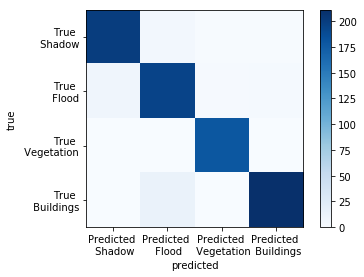

In [235]:
# Print confusion matrix for linear kernel SVM
print(confusion_matrix(ytest, ypred))
plt.imshow(confusion_matrix(ytest, ypred),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow', 'Predicted \n Flood',
                          'Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow', 'True \n Flood',
                          'True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [236]:
# Define SVM classifier with rbf kernel
clf_rbf = SVC(kernel='rbf')
clf_rbf.fit(Xtrain, ytrain)
ypred_rbf = clf_rbf.predict(Xtest)
accuracy_score(ytest, ypred_rbf)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.9329268292682927

In [ ]:
# Commented out to avoid overwriting
# Save out SVM classifier with rbf kernel, accuracy score of 0.9406528189910979
# pickle.dump(clf_rbf, open(combined_svm_outputs_path+'pickle_combined_svm_rbf_final', 'wb'))

[[198   6   2   1]
 [ 23 179   2   5]
 [  0   0 179   0]
 [  0  16   0 209]]


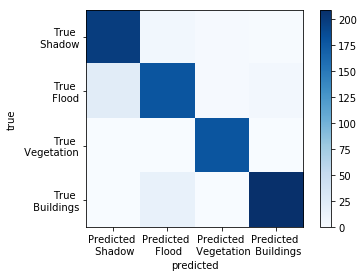

In [237]:
# Print confusion matrix for rbf kernel SVM
print(confusion_matrix(ytest, ypred_rbf))
plt.imshow(confusion_matrix(ytest, ypred_rbf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow',
                          'Predicted \n Flood',
                          'Predicted \n Vegetation',
                          'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow', 'True \n Flood',
                          'True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

# Validation with 40% of data held back from SVM model development

In [238]:
# Load saved SVM classifer
loaded_clf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_svm_final_v2', 'rb'))

# Apply linear kernel SVM classifier to external dataset
ypred_valid = clf.predict(Xext)
accuracy_score(yext, ypred_valid)

0.9334308705193856

[[319   9   2   1]
 [ 26 302   0   2]
 [  0   2 344   0]
 [  1  48   0 311]]


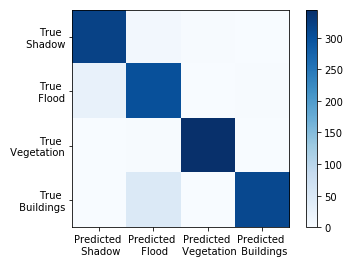

In [239]:
# Print confusion matrix for linear kernel SVM
print(confusion_matrix(yext, ypred_valid))

plt.imshow(confusion_matrix(yext, ypred_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow',
                          'Predicted \n Flood',
                          'Predicted \n Vegetation',
                          'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow', 'True \n Flood', '
                          True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)

In [240]:
# Write out confusion matrix array
confusion_svm_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_svm_external).to_csv(
    combined_svm_outputs_path+'confusion_svm_external_additional_points_v4.csv')

0.9151515151515152

[[  0   0   0]
 [ 26 302   2]
 [  0   0   0]]


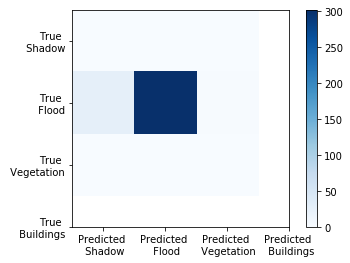

In [241]:
# Create df with predicted and reference data
# Subset df to focus only on flood, all other reference points (shadow, other) removed
ypred_df = pd.DataFrame(ypred_valid)
yext_df = pd.DataFrame(yext)
external_xy = pd.concat([yext_df, ypred_df], axis=1, sort=False)
external_xy.columns = ['ClassValue', 'ypred_valid']
external_xy.head()
flood_only_accuracy = external_xy[external_xy.ClassValue == 2]

# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy['ClassValue']
ypred_flood_only = flood_only_accuracy['ypred_valid']
print(accuracy_score(ytest_flood_only, ypred_flood_only))
print('')

# Calculate confusion matrix for flood only subset
print(confusion_matrix(ytest_flood_only, ypred_flood_only))
plt.imshow(confusion_matrix(ytest_flood_only, ypred_flood_only),
           cmap='Blues', interpolation='nearest')

plt.xticks(np.arange(4), ('Predicted \n Shadow',
                          'Predicted \n Flood',
                          'Predicted \n Vegetation',
                          'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow',
                          'True \n Flood',
                          'True \n Vegetation',
                          'True \n Buildings'))
plt.colorbar()
plt.grid(False)

In [242]:
# Load saved SVM classifer with rbf kernel
loaded_clf_rbf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_svm_rbf_final', 'rb'))

# Apply rbf kernel SVM classifier to external dataset
ypred_rbf_valid = loaded_clf_rbf.predict(Xext)
accuracy_score(yext, ypred_rbf_valid)

0.9180687637161667

[[315  12   4   0]
 [ 32 292   1   5]
 [  0   2 344   0]
 [  1  54   1 304]]


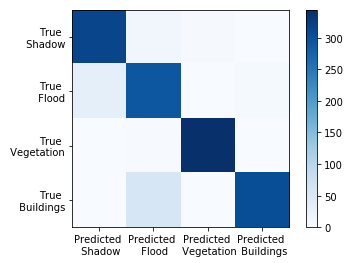

In [243]:
# Print confusion matrix for rbf kernel SVM
print(confusion_matrix(yext, ypred_rbf_valid))

plt.imshow(confusion_matrix(yext, ypred_rbf_valid),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow',
                          'Predicted \n Flood',
                          'Predicted \n Vegetation',
                          'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow',
                          'True \n Flood',
                          'True \n Vegetation',
                          'True \n Buildings'))
plt.colorbar()
plt.grid(False)

# Plot map based on trained SVM model with linear kernel

In [244]:
# Select all raw/index value arrays needed for model inputs
koumassi_raw_list = glob(koumassi_raster_outputs_path+"\\"+"*raw*")
koumassi_raw_list.sort()
southeast_raw_list = glob(southeast_raster_outputs_path+"\\"+"*raw*")
southeast_raw_list.sort()

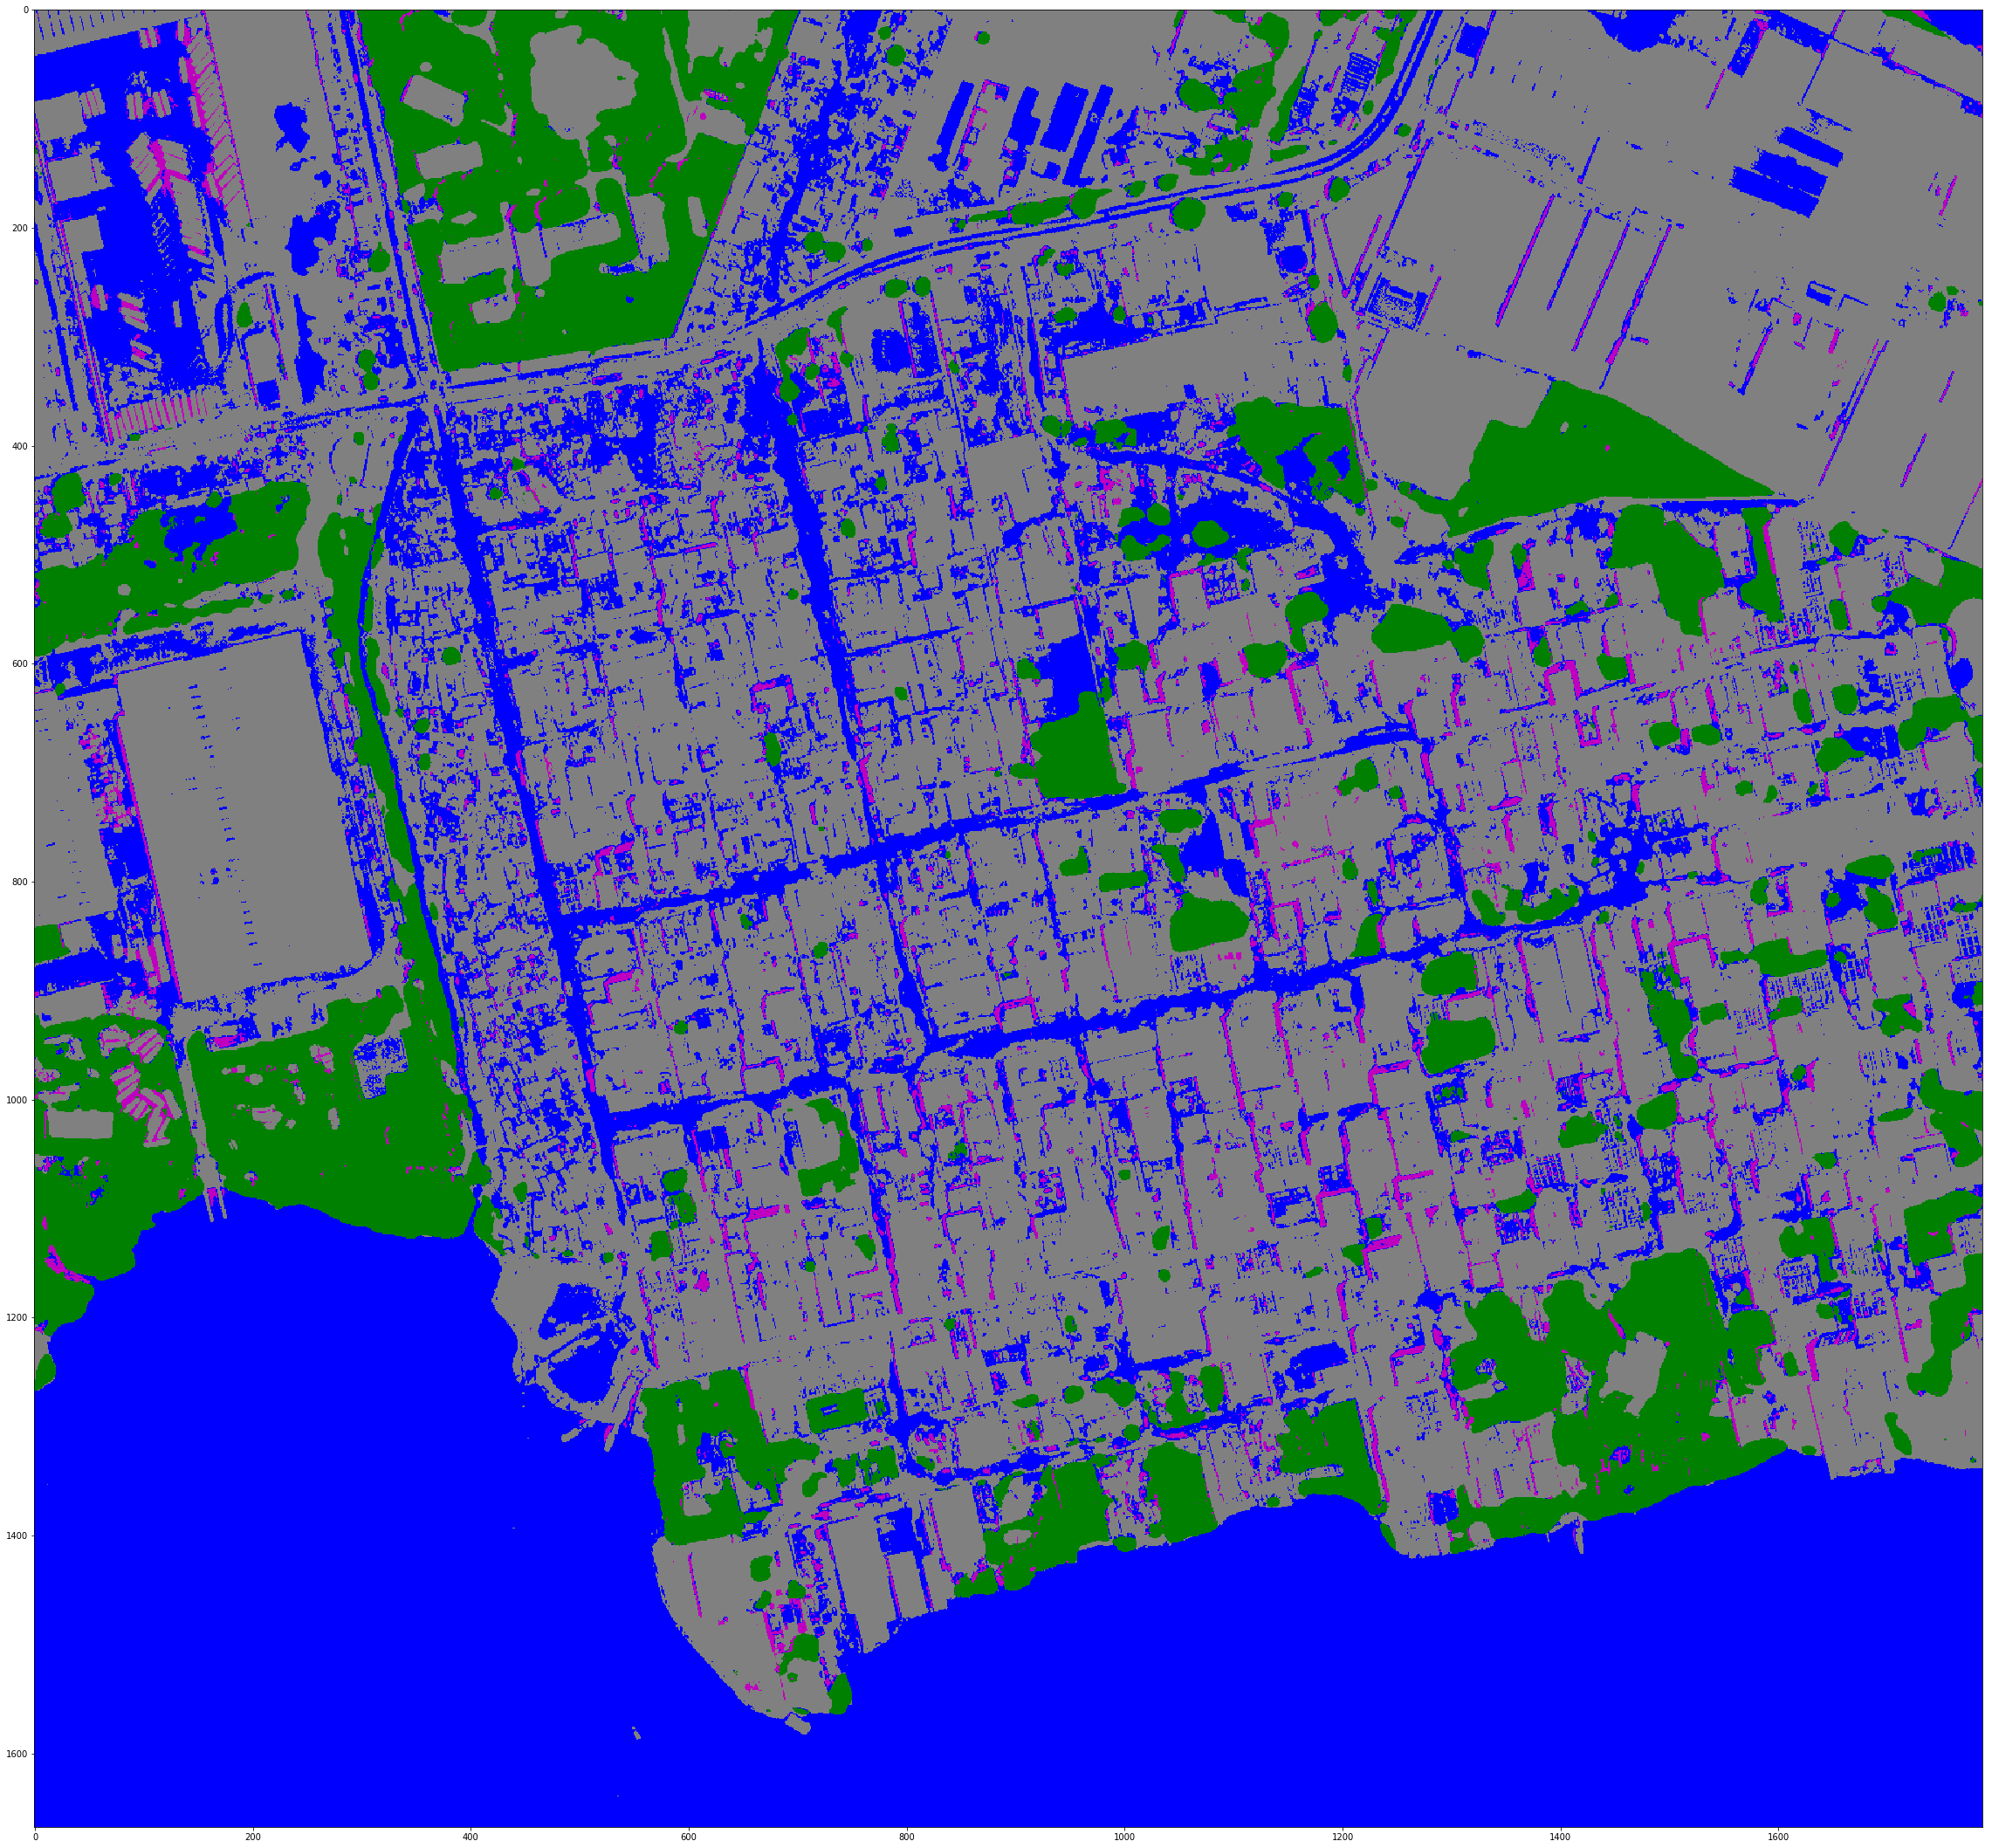

In [245]:
# Create stack of inputs for entire Koumassi image and apply saved linear SVM classifer
from matplotlib.colors import ListedColormap
koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3) # Update based on number of model params
X_koumassi_index = koumassi_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_koumassi_index)

# Plot SVM map for Koumassi
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [246]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'koumassi_SVM_map_combined_final.tif', 
              'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

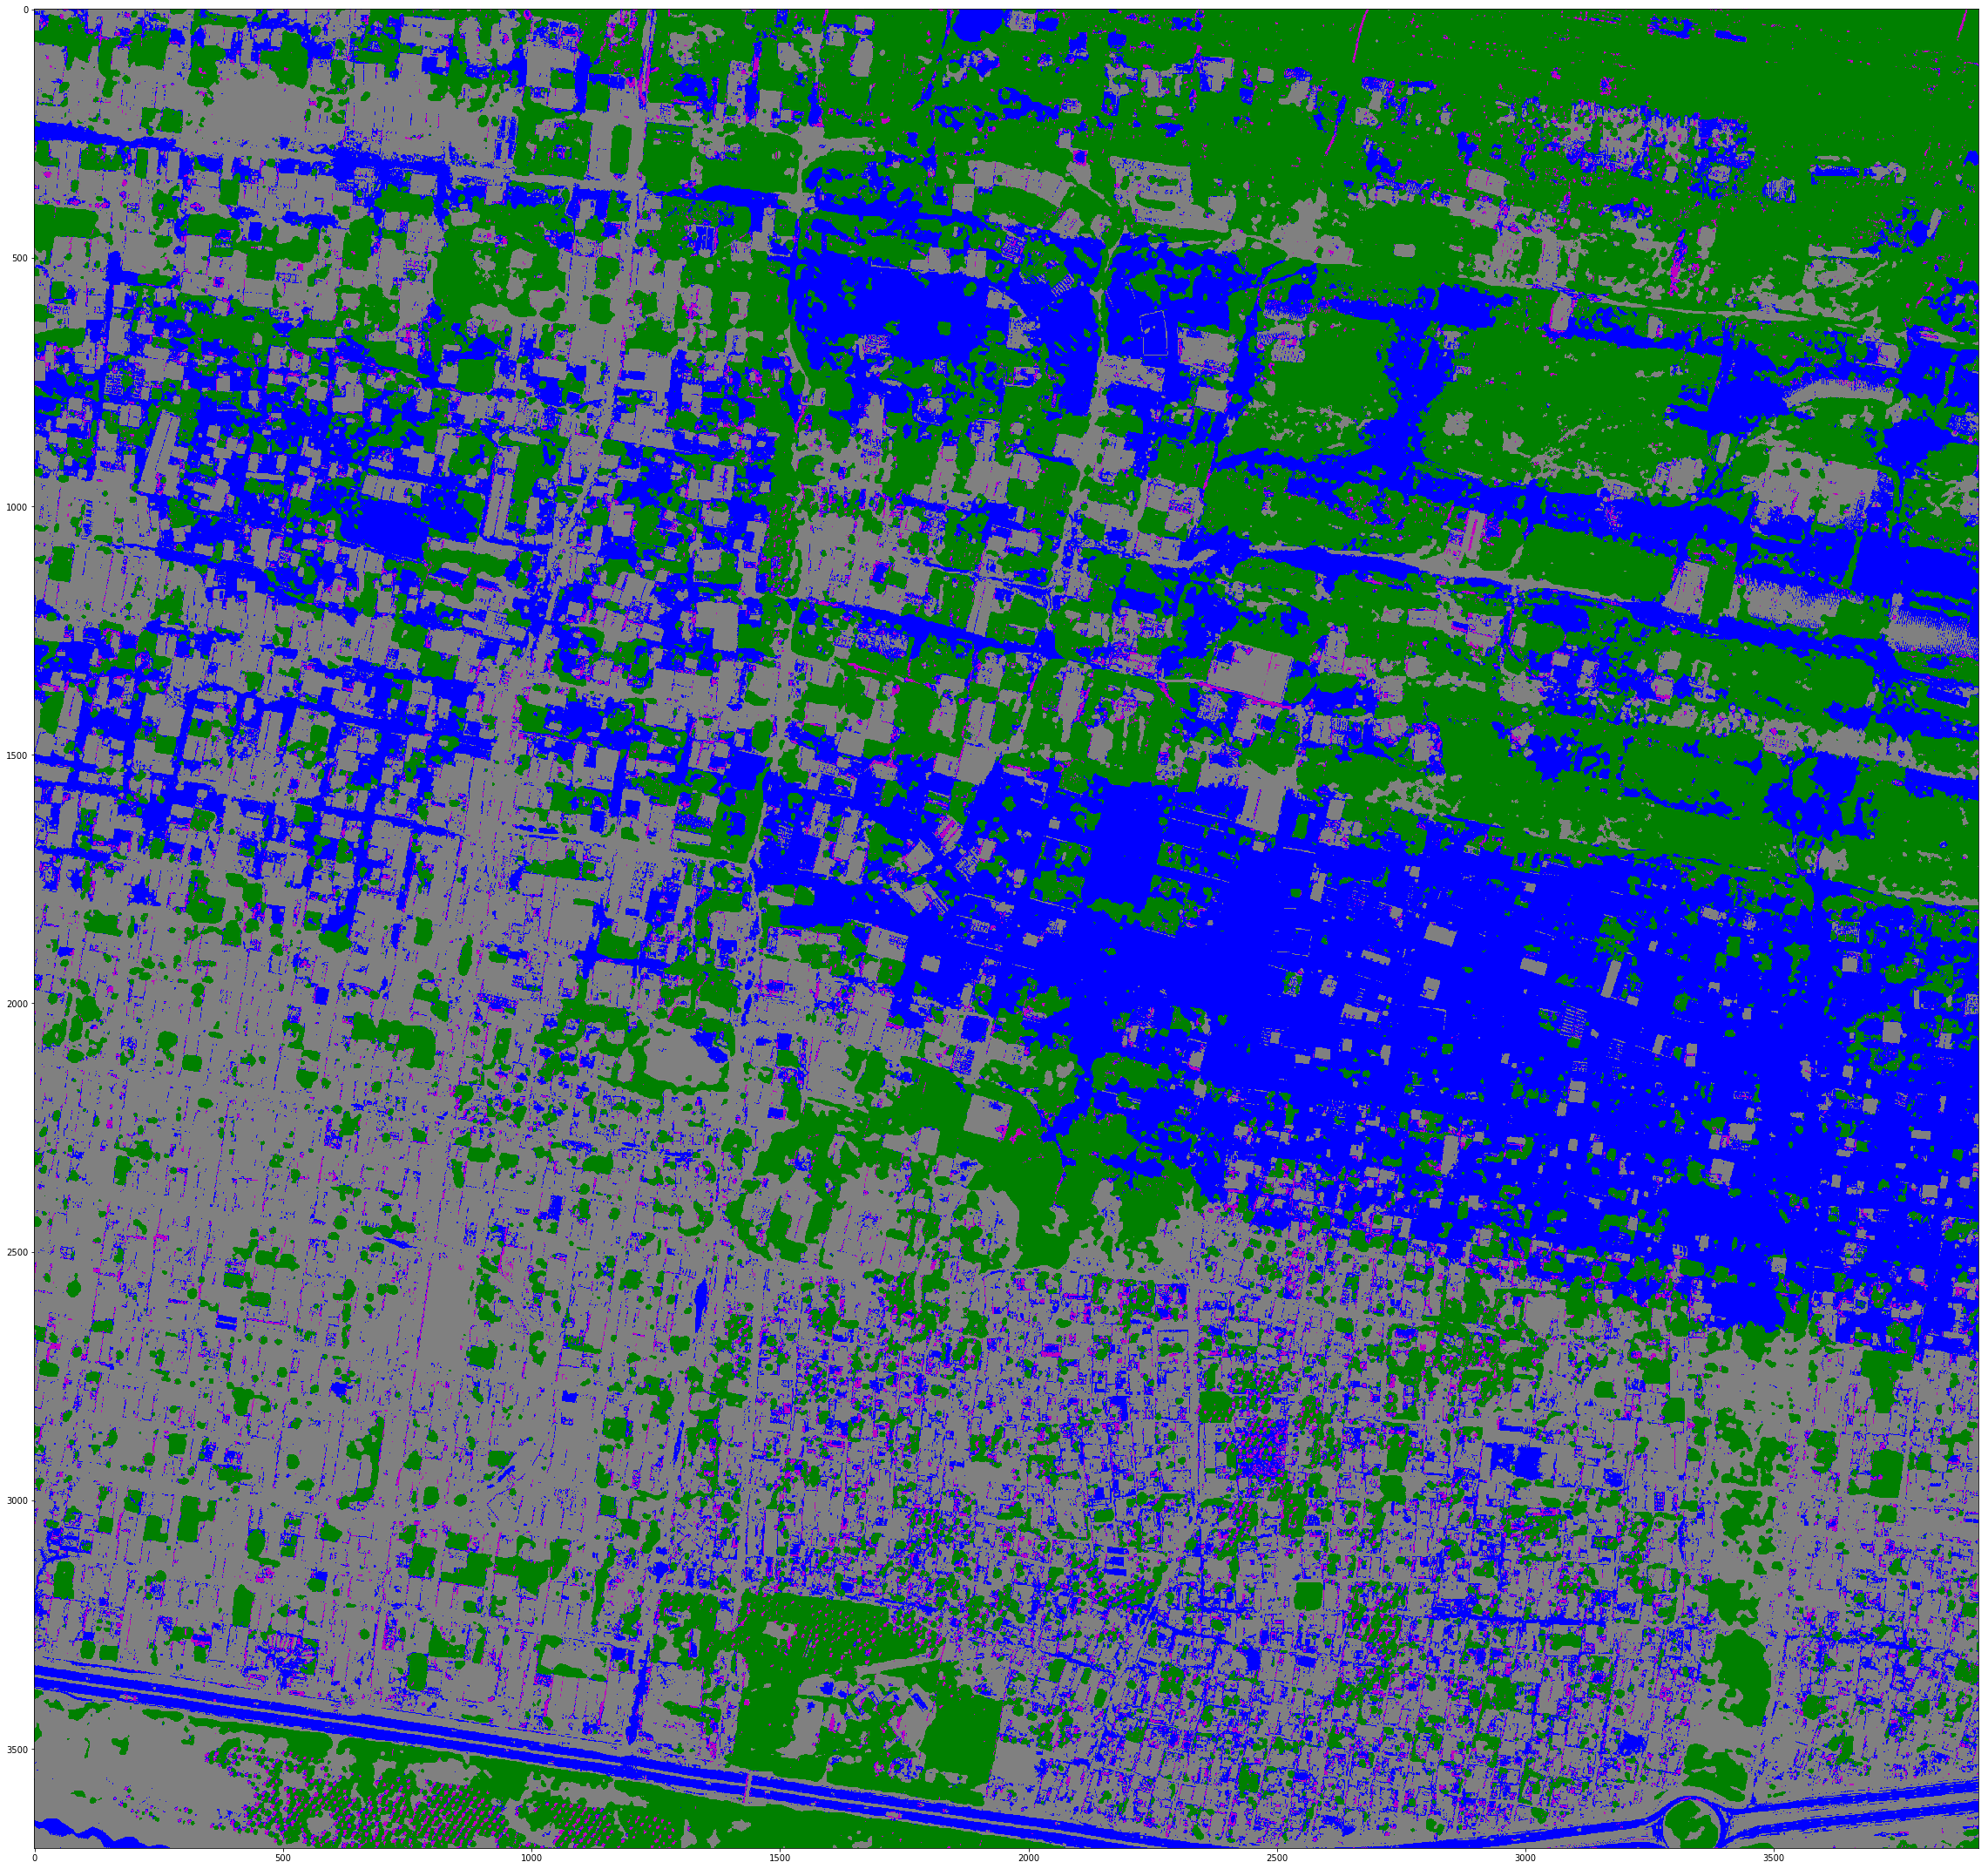

In [247]:
# Create stack of inputs for entire Southeast image and apply saved linear SVM classifer
from matplotlib.colors import ListedColormap
southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3)
# Update based on number of model params
X_southeast_index = southeast_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot SVM map for Southeast
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [42]:
# Write out SVM map
with rio.open(combined_svm_outputs_path+'southeast_SVM_map_combined_final.tif', 
              'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

# Define and apply random forest

In [248]:
# Define random forest classifier
clf_random_forest = RandomForestClassifier(
    n_estimators=100, max_depth=2, random_state=10)

In [249]:
# Split training dataset, test size is 40%, training size 60%
# Iterate until accuracy score is satisfactory
Xtrain_rf, Xtest_rf, ytrain_rf, ytest_rf = train_test_split(
    Xint, yint, test_size=0.4)

In [250]:
# Apply random forest classifier
clf_random_forest.fit(Xtrain_rf, ytrain_rf)
ypred_random_forest = clf_random_forest.predict(Xtest_rf)
accuracy_score(ytest_rf, ypred_random_forest)

C:\Users\katy\Anaconda3\envs\earth-analytics-python\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


0.9207317073170732

In [57]:
# Commented out to avoid overwriting final classifier
# Save out random forest classfier with accuracy score of 0.9304878048780488
# pickle.dump(clf_random_forest, open(combined_svm_outputs_path+'pickle_combined_RF_final', 'wb'))

[[197   3   2   0]
 [ 27 166   0   6]
 [  0   2 195   2]
 [  0  11   4 205]]


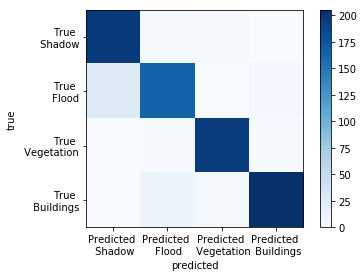

In [58]:
# Print confusion matrix for random forest
print(confusion_matrix(ytest_rf, ypred_random_forest))
plt.imshow(confusion_matrix(ytest_rf, ypred_random_forest),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow', 'Predicted \n Flood',
                          'Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow', 'True \n Flood',
                          'True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

# Validation with 40% of data held back from random forest model development

In [200]:
# Load saved random forest classifer
loaded_clf_rf = pickle.load(
    open(combined_svm_outputs_path+'pickle_combined_RF_final', 'rb'))

In [201]:
# Apply linear kernel random forest classifier to external dataset
ypred_valid_rf = loaded_clf_rf.predict(Xext)
accuracy_score(yext, ypred_valid_rf)

0.9173372348207754

[[302  12   1   1]
 [ 47 265   0  29]
 [  0   1 323   4]
 [  0  34   0 348]]


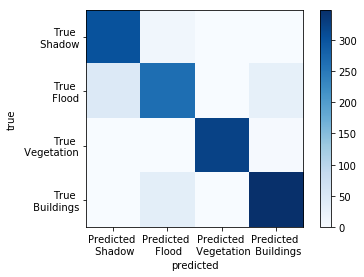

In [61]:
# Print confusion matrix for random forest
print(confusion_matrix(yext, ypred_valid_rf))

plt.imshow(confusion_matrix(yext, ypred_valid_rf),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(4), ('Predicted \n Shadow', 'Predicted \n Flood',
                          'Predicted \n Vegetation', 'Predicted \n Buildings'))
plt.yticks(np.arange(4), ('True \n Shadow', 'True \n Flood',
                          'True \n Vegetation', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted')

In [62]:
# Write out confusion matrix
confusion_rf_external = confusion_matrix(yext, ypred_valid)
pd.DataFrame(confusion_rf_external).to_csv(
    combined_svm_outputs_path+'confusion_rf_external_final.csv')

0.7771260997067448
[[  0   0   0]
 [ 47 265  29]
 [  0   0   0]]


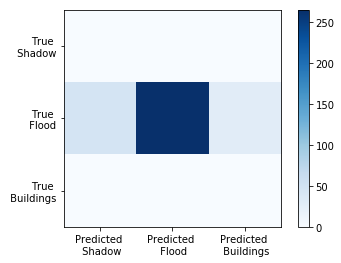

In [63]:
# Create df with predicted and reference data
# Subset df to focus only on flood, all other reference points (shadow, other) removed
ypred_rf_df = pd.DataFrame(ypred_valid_rf)
yext_df = pd.DataFrame(yext)
external_xy_rf = pd.concat([yext_df, ypred_rf_df], axis=1, sort=False)
external_xy_rf.columns = ['ClassValue', 'ypred_valid_rf']
external_xy_rf.head()
flood_only_accuracy_rf = external_xy_rf[external_xy_rf.ClassValue == 2]

# Calculate accuracy score for flood only subset
ytest_flood_only = flood_only_accuracy_rf['ClassValue']
ypred_flood_only = flood_only_accuracy_rf['ypred_valid_rf']
print(accuracy_score(ytest_flood_only, ypred_flood_only))

# Print confusion matrix for flood only subset
print(confusion_matrix(ytest_flood_only, ypred_flood_only))
plt.imshow(confusion_matrix(ytest_flood_only, ypred_flood_only),
           cmap='Blues', interpolation='nearest')
plt.xticks(np.arange(3), ('Predicted \n Shadow',
                          'Predicted \n Flood', 'Predicted \n Buildings'))
plt.yticks(np.arange(3), ('True \n Shadow',
                          'True \n Flood', 'True \n Buildings'))
plt.colorbar()
plt.grid(False)

# Plot map based on trained random forest model

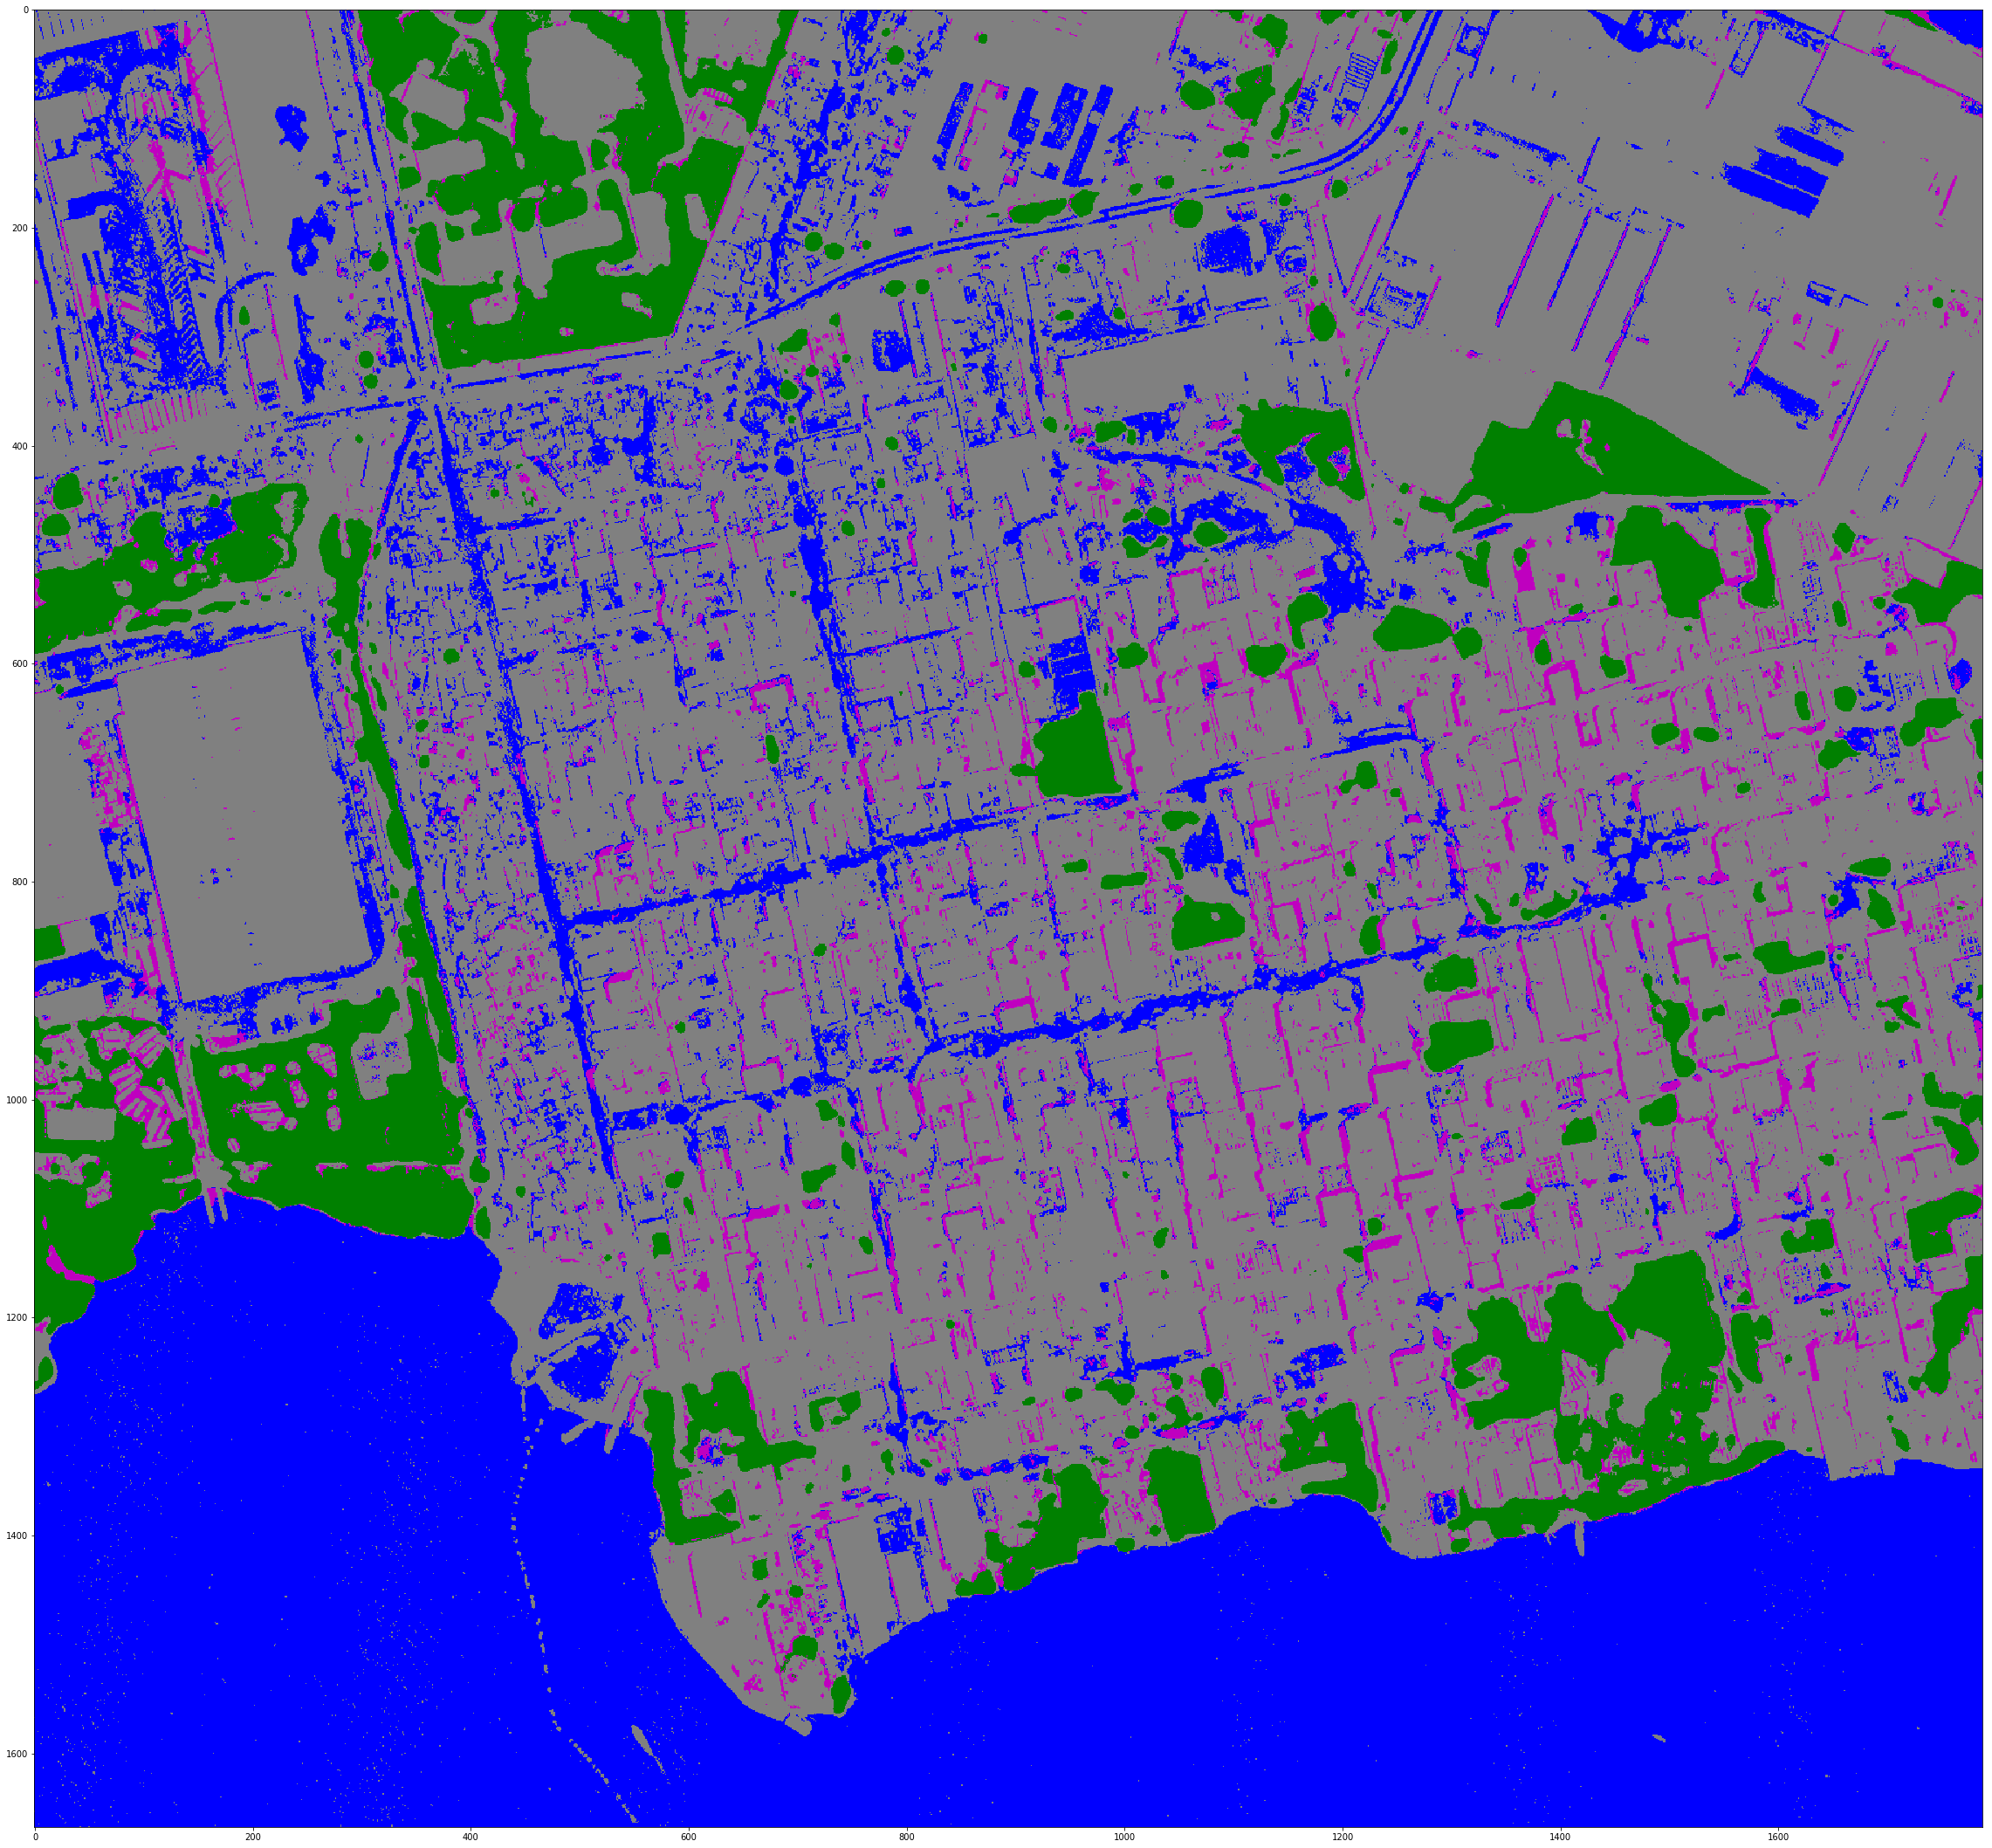

In [64]:
# Create stack of inputs for entire image and apply saved random forest classifer
from matplotlib.colors import ListedColormap
koumassi_index_stack, k_meta = es.stack(koumassi_raw_list)
koumassi_index_im = np.rollaxis(koumassi_index_stack, 0, 3)# Update based on number of model params
X_koumassi_index = koumassi_index_im.reshape(-1, 8)
predictedClass = loaded_clf_rf.predict(X_koumassi_index)

# Plot random forest map for Koumassi
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(koumassi_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [65]:
# Write out random forest tif for Koumassi
with rio.open(combined_svm_outputs_path+'koumassi_RF_map_combined_final.tif', 
              'w', **koumassi_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)

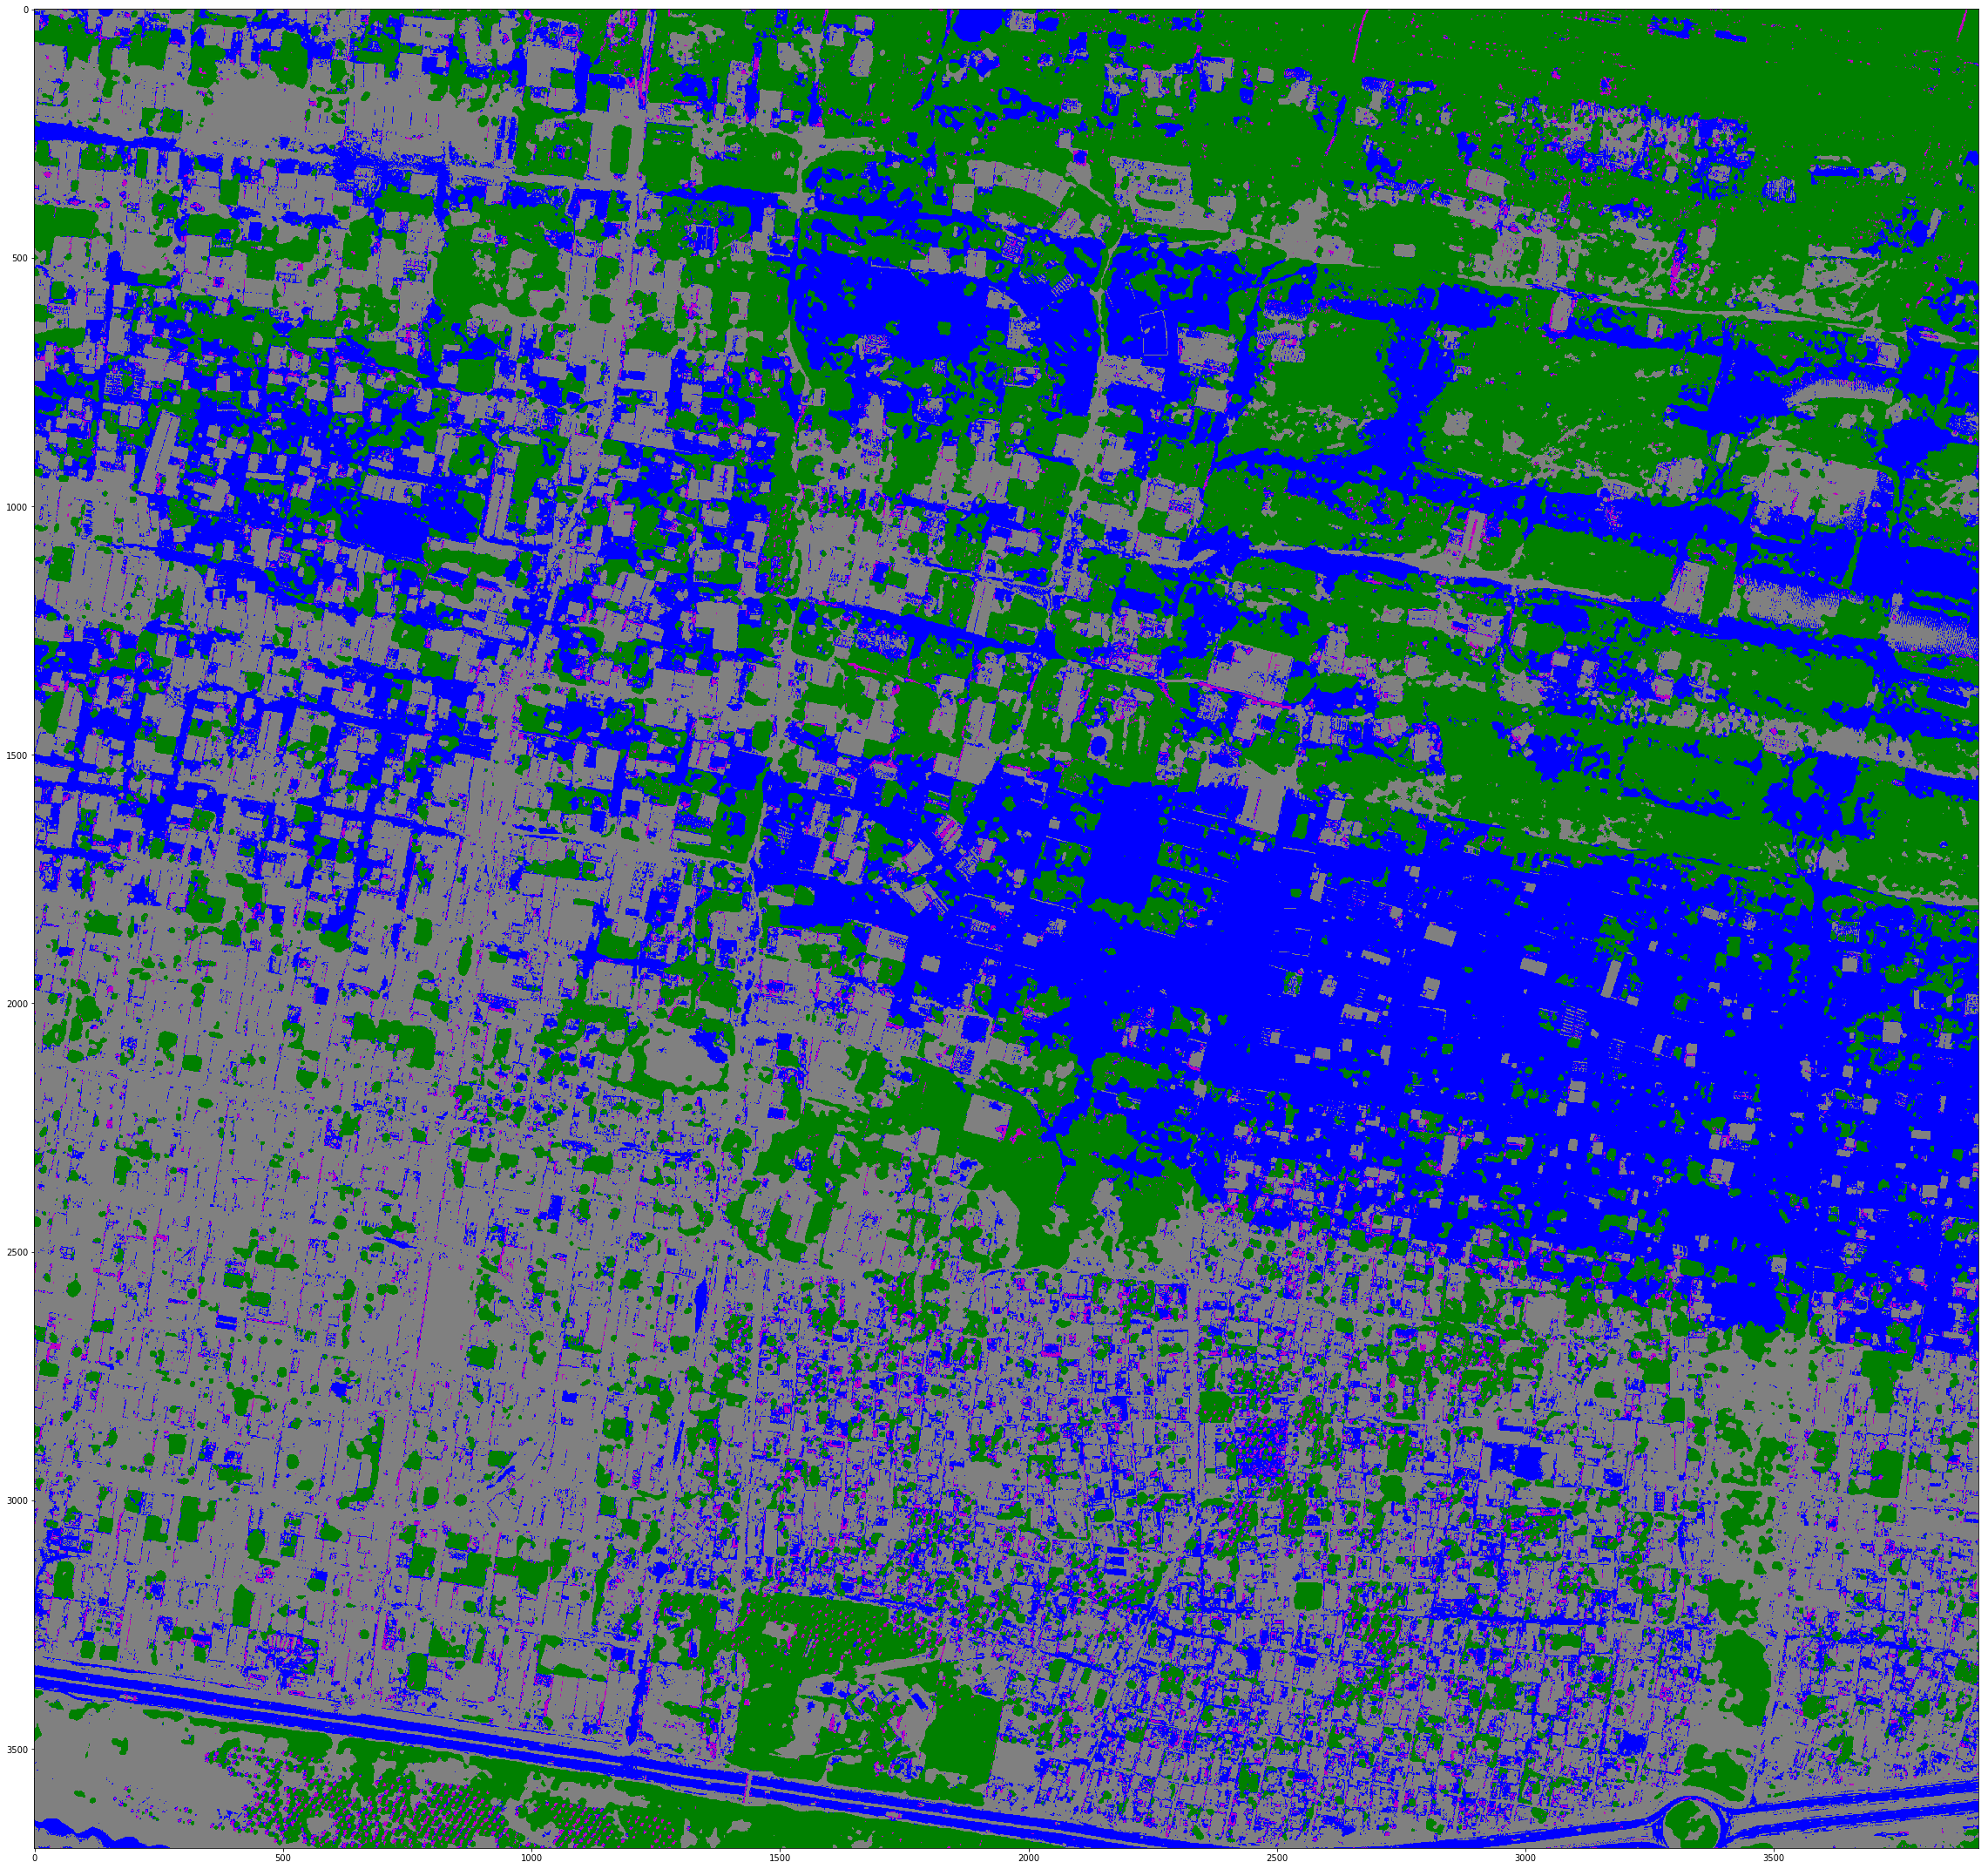

In [66]:
# Create stack of inputs for entire image and apply saved random forest classifer
from matplotlib.colors import ListedColormap
southeast_index_stack, se_meta = es.stack(southeast_raw_list)
southeast_index_im = np.rollaxis(southeast_index_stack, 0, 3) # Update based on number of model params
X_southeast_index = southeast_index_im.reshape(-1, 8)
predictedClass = loaded_clf.predict(X_southeast_index)

# Plot random forest map for southeast
fig, ax = plt.subplots(figsize=(40, 40))
pred_data = predictedClass.reshape(southeast_index_im.shape[:2])
cmap = ListedColormap(['m', 'blue', 'green', 'grey'])
ax.imshow(pred_data, cmap=cmap)
plt.show()

In [67]:
# Write out random forest tif for Southeast
with rio.open(combined_svm_outputs_path+'southeast_RF_map_combined_final.tif', 
              'w', **southeast_files_out_meta) as dst:
    dst.write(pred_data.astype('float32'), 1)